In [67]:
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import math

In [8]:
user_ids = []
with open('selected-users.txt', "r") as f:
    for line in f:
        user_ids.append(line.strip())
print("Usuários selecionados: {}".format(len(user_ids)))

Usuários selecionados: 2901


In [10]:
reviews_by_user = {}
reviews_counter = 0
with open("./yelp/yelp_academic_dataset_review.json", encoding="utf8") as f:
    for line in f:
        review = json.loads(line)
        if review['user_id'] in user_ids:
            if review['user_id'] not in reviews_by_user:
                reviews_by_user[review['user_id']] = []
            reviews_by_user[review['user_id']].append(review)
            reviews_counter += 1
           
print("Reviews selecionadas: {}".format(reviews_counter))

Reviews selecionadas: 47687


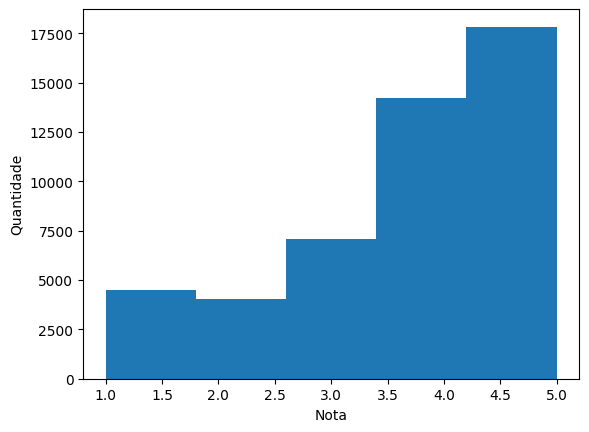

In [86]:
stars = []
for i in range(0, len(user_ids)):
    for review in reviews_by_user[user_ids[i]]:
        stars.append(review['stars'])
    
plt.hist(stars, bins=5)
plt.ylabel('Quantidade')
plt.xlabel('Nota');

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2901/2901 [02:26<00:00, 19.84it/s]


Número de usuários: 2901
Número de amizades: 109922
Número de médio de amigos: 37.891072044122716


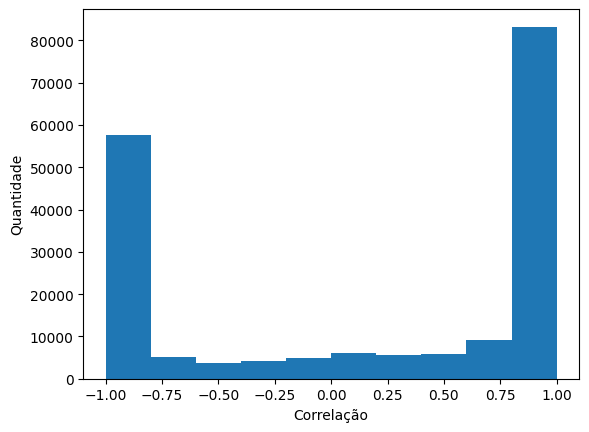

In [79]:
def find_review_by_business(reviews, business_id):
    return next(filter(lambda r: r['business_id'] == business_id, reviews))

def scale(value):
    return (value - 2.5) / 2.5

def pearson_correlation(a_reviews, b_reviews) -> float:
    if len(a_reviews) > 1 and len(b_reviews) > 1: 
        common_business = set(map(lambda r: r['business_id'], a_reviews)).intersection(set(map(lambda r: r['business_id'], b_reviews)))
        if len(common_business) > 0:
            a_common_reviews = list(filter(lambda r: r['business_id'] in common_business, a_reviews))
            b_common_reviews = list(filter(lambda r: r['business_id'] in common_business, b_reviews))
            avg_a = sum(map(lambda r: scale(r['stars']), a_reviews)) / (len(a_reviews) + 0.000001) ## Avoid division by 0
            avg_b = sum(map(lambda r: scale(r['stars']), b_reviews)) / (len(b_reviews) + 0.000001) ## Avoid division by 0
            a_product = math.sqrt(sum(map(lambda r: (scale(r['stars']) - avg_a) ** 2, a_common_reviews)))
            b_product = math.sqrt(sum(map(lambda r: (scale(r['stars']) - avg_b) ** 2, b_common_reviews)))
            cross_product = sum(map(lambda business_id: (scale(find_review_by_business(a_common_reviews, business_id)['stars']) - avg_a) * 
                                                        (scale(find_review_by_business(b_common_reviews, business_id)['stars']) - avg_b), 
                                    common_business))
            return cross_product / (a_product * b_product)
    return 0.0

## Testing Pearson Correlation
#print(pearson_correlation([{'business_id': 1, 'stars': 5}, {'business_id': 2, 'stars': 4.5}], 
#                          [{'business_id': 1, 'stars': 5}, {'business_id': 2, 'stars': 5}]))

correlations = []
G = nx.Graph()
for i in tqdm(range(0, len(user_ids))):
    G.add_node(user_ids[i])
    for j in range(i + 1, len(user_ids)):
        if user_ids[j] not in G.nodes():
            G.add_node(user_ids[j])
        cor = pearson_correlation(reviews_by_user[user_ids[i]], reviews_by_user[user_ids[j]])
        if cor != 0:
            correlations.append(cor)
        if cor > 0:
            G.add_edge(user_ids[i], user_ids[j], weight=cor)

plt.hist(correlations, bins=51)
plt.ylabel('Quantidade')
plt.xlabel('Correlação');

print("Número de usuários: {}".format(len(G.nodes())))
print("Número de amizades: {}".format(len(G.edges())))
print("Número de médio de amigos: {}".format(len(G.edges()) / len(G.nodes())))

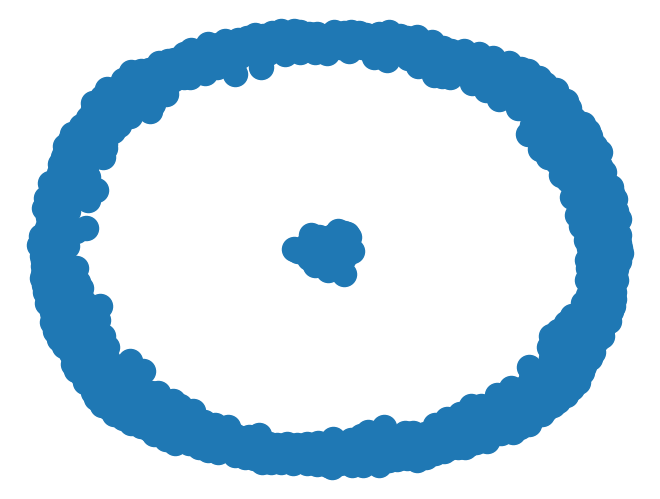

In [72]:
nx.draw(G, pos=nx.spring_layout(G))

In [73]:
degree_g = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict({
'node': list(degree_g.keys()),
'centrality': list(degree_g.values())
})
degree_df = degree_df.sort_values('centrality', ascending=False).head(50)
degree_df

,node,centrality
392,B3s7gBz3NMFOaNvrzWzLIA,0.225172
299,Hxx8FmhpxiugIrGRh8RDOg,0.212069
2326,PnwOegp7RXfMeNAyO9fQhQ,0.208621
2116,I-wq3PJNBlaZ8tpi0SdS8A,0.204483
140,Qjd7aIiKqnd68IfaR2EPoA,0.200690
7,TESUeCPNTpoovu7sJypdzw,0.196897
276,I86B4Am5uRN6Aq1F0X7Sxg,0.196207
228,x-YPpdVPOOV4TLC49HuP6w,0.187586
1004,mKBl4fAqTfNts7B78aOPVg,0.183103
1661,iPkdNziqnhNukjnmsrSzmg,0.181034


In [74]:
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
print("Número de usuários: {}".format(len(Gcc.nodes())))
print("Número de amizades: {}".format(len(Gcc.edges())))
print("Número de médio de amigos: {}".format(len(Gcc.edges()) / len(Gcc.nodes())))

Número de usuários: 2030
Número de amizades: 102331
Número de médio de amigos: 50.40935960591133


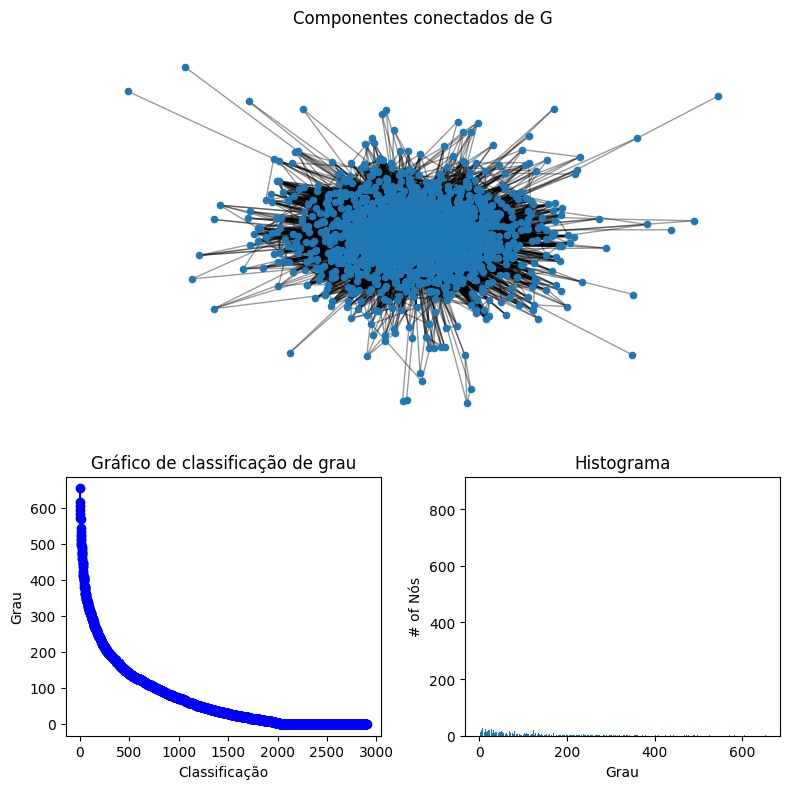

In [75]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Grau da rede de usuários", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])

pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Componentes conectados de G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Gráfico de classificação de grau")
ax1.set_ylabel("Grau")
ax1.set_xlabel("Classificação")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Histograma")
ax2.set_xlabel("Grau")
ax2.set_ylabel("# of Nós")

fig.tight_layout()
plt.show()

In [76]:
nx.write_gml(G, "users-similarity.gml")

## Caracteristicas

Rede Conectada